# Introduction 

**This is a basic CNN Model training notebook**

It is based on: 
- Thumbnail images
- Basic data transformation (using Albumentation):
    - resizing images to 512x512
    - normalizing pixel values
- CNN Architecture


**Todos:**

- Learn about Dataset & DataLoader
- add augmentations (albumentation)
- gem pooling

In [1]:
# !pip install --quiet torch_optimizer
# import torch_optimizer as torch_optimizer


In [2]:
!pip install --quiet mlflow dagshub
import mlflow.pytorch 
from mlflow import MlflowClient
import dagshub


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:


import os
import gc
import cv2
import datetime
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
from skimage import io


# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.cuda import amp
import torchvision

import optuna
from optuna.trial import TrialState

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict


from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score
from torch.utils.data.sampler import WeightedRandomSampler

# For Image Models
import timm

from getpass import getpass

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
# warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
from ubc_utils_models import UBCBinaryModel
from ubc_utils_train import get_optimizer, fetch_scheduler, EarlyStopping
from ubc_utils_infrastructure import  print_logged_info, get_or_create_experiment_id
# from ubc_utils_datasets import 

In [5]:
os.environ["MLFLOW_TRACKING_USERNAME"]="Niggl0n"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "7a3590e8c5558d4598dacc7810befa70a4baac9e"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "UBC_Cancer_Classification"
#dagshub.auth.add_app_token("7a3590e8c5558d4598dacc7810befa70a4baac9e")
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

In [6]:
CONFIG = {
    "weighted_loss": False,
    "datetime_now": datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), 
    "n_fold":5, 
    "test_fold": 0,
    "valid_fold": 2,
    "seed": 42,
    "img_size": 512,
    "model_name": "tf_efficientnet_b0_ns",   # "tf_efficientnet_b0_ns", # "tf_efficientnetv2_s_in21ft1k"
    "checkpoint_path": "/kaggle/input/tf-efficientnet-b0-aa-827b6e33-pth/tf_efficientnet_b0_aa-827b6e33.pth",
    "num_classes": 5,
    "train_batch_size": 8,
    "valid_batch_size": 8,
    "n_tiles": 10,
    "n_tiles_test": 10,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "num_epochs": 15,
    "early_stopping": True,
    "patience": 4,
    "optimizer": 'adam',
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 10,
    "momentum": 0.9,
    "weight_decay": 1e-4,
}

## 1. Data Preparation

In [7]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25'
df_orig = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_orig = df_orig.rename(columns={"label":"subtype"})
df_train = pd.read_csv("/kaggle/input/df-tiles-025x-cancer-tissue-binary-labels/tiles_labelled_binary_cancer.csv", index_col="Unnamed: 0")  # this dataframe is based on the masks given by the competition hosts
display(df_orig.sample(5))
display(df_train.sample(5))


,image_id,subtype,image_width,image_height,is_tma
526,63941,HGSC,47123,36600,False
401,47431,MC,67495,46563,False
424,50962,EC,59670,39962,False
310,37655,HGSC,56807,35254,False
421,50712,HGSC,67800,26380,False


,image_path,mask_path,cancer_ratio,non_cancer_ratio,label
14247,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.415031,0.0,cancer
5413,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.000000,0.0,unknown
31220,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.000000,0.0,unknown
8699,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.000000,0.0,unknown
4312,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.577633,0.0,cancer


<Axes: >

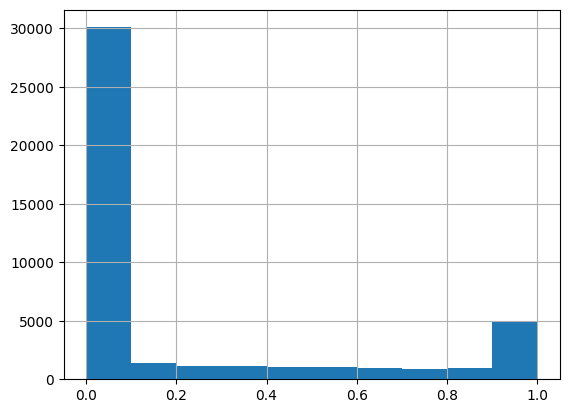

In [8]:
df_train.cancer_ratio.hist()

<Axes: >

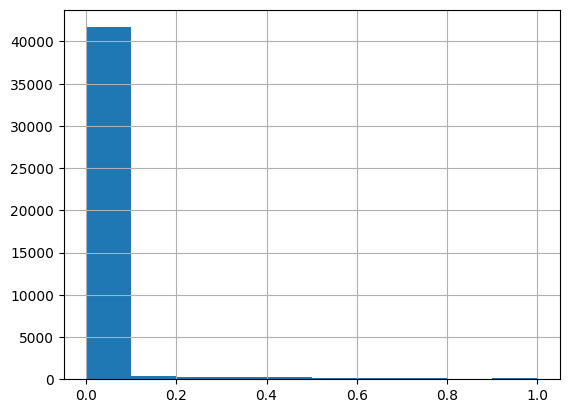

In [9]:
df_train["non_cancer_ratio"].hist()

<Axes: >

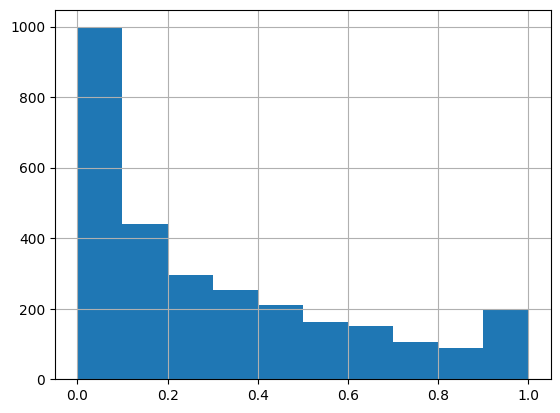

In [10]:
df_train[df_train["non_cancer_ratio"]!=0]["non_cancer_ratio"].hist()

<Axes: >

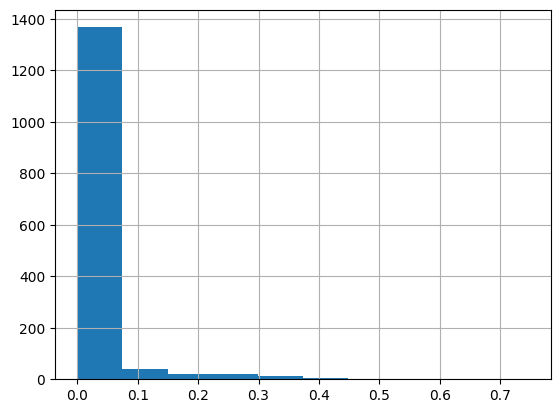

In [11]:
df_train[df_train["non_cancer_ratio"]>=0.2]["cancer_ratio"].hist()

<Axes: >

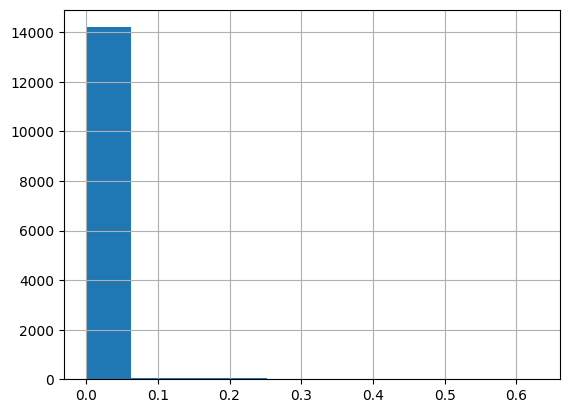

In [12]:
df_train[df_train["cancer_ratio"]>=0.05]["non_cancer_ratio"].hist()

In [13]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=CONFIG["seed"],)
for fold, ( _, val_) in enumerate(skf.split(X=df_orig, y=df_orig.subtype)):
    df_orig.loc[val_ , "kfold"] = int(fold)
display(df_orig.head())


    # sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG["seed"])

,image_id,subtype,image_width,image_height,is_tma,kfold
0,4,HGSC,23785,20008,False,4.0
1,66,LGSC,48871,48195,False,2.0
2,91,HGSC,3388,3388,True,5.0
3,281,LGSC,42309,15545,False,2.0
4,286,EC,37204,30020,False,2.0


In [14]:
df_train.label.value_counts()

label
unknown       24962
cancer        16055
non-cancer     2571
Name: count, dtype: int64

In [15]:
df_train["image_id"] = df_train["image_path"].map(lambda x: int(x.split('/')[-2]))  # get image id
df_train = df_train[~df_train["image_path"].str.lower().str.contains("tma")]  # remove tma
df_train = df_train[df_train["label"]!="unknown"].reset_index(drop=True)  # remove non labelled tiles

min_cancer_th = 0.05
df_train.loc[df_train.cancer_ratio>min_cancer_th, "label"] = "cancer"
df_train = pd.merge(df_train, df_orig, on="image_id", how="left")
df_train["group"] = df_train["label"] + "_" + df_train["subtype"] 

display(df_train.image_id.nunique())
display(df_train.is_tma.value_counts())

encoder = LabelEncoder()
df_train['target_label'] = encoder.fit_transform(df_train['label'])
with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)
df_train.to_csv("df_data_binary_classification.csv", index=False)

# separate train and test dataset
df_test = df_train[df_train["kfold"]==CONFIG["test_fold"]].reset_index(drop=True)
df_valid = df_train[df_train["kfold"]==CONFIG["valid_fold"]].reset_index(drop=True)
df_train = df_train[~df_train["kfold"].isin([CONFIG["valid_fold"],CONFIG["test_fold"]])].reset_index(drop=True)
print(f"Shape df_train: {df_train.shape}, Shape df_test: {df_valid.shape}, Shape df_test: {df_test.shape} ")
df_train.head()

152

is_tma
False    18303
Name: count, dtype: int64

Shape df_train: (11613, 13), Shape df_test: (2778, 13), Shape df_test: (3912, 13) 


,image_path,mask_path,cancer_ratio,non_cancer_ratio,label,image_id,subtype,image_width,image_height,is_tma,kfold,group,target_label
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.013496,0.000000,cancer,53688,HGSC,26591,29871,False,5.0,cancer_HGSC,0
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.602837,0.000000,cancer,53688,HGSC,26591,29871,False,5.0,cancer_HGSC,0
2,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.000000,0.598656,non-cancer,53688,HGSC,26591,29871,False,5.0,non-cancer_HGSC,1
3,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.154850,0.000000,cancer,53688,HGSC,26591,29871,False,5.0,cancer_HGSC,0
4,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.088707,0.000000,cancer,53688,HGSC,26591,29871,False,5.0,cancer_HGSC,0


In [16]:
display(df_train.label.value_counts())
display(df_train.subtype.value_counts())
display(df_valid.subtype.value_counts())
display(df_test.subtype.value_counts())

label
cancer        10060
non-cancer     1553
Name: count, dtype: int64

subtype
HGSC    3492
EC      2403
MC      2154
CC      1994
LGSC    1570
Name: count, dtype: int64

subtype
HGSC    995
EC      533
LGSC    518
CC      445
MC      287
Name: count, dtype: int64

subtype
HGSC    2109
EC      1007
CC       307
LGSC     302
MC       187
Name: count, dtype: int64

In [17]:
df_train.image_id.nunique(), df_test.image_id.nunique()

(97, 29)

In [18]:
set(df_train.image_id) & set(df_valid.image_id)

set()

In [19]:
set(df_train.image_id) & set(df_test.image_id)

set()

In [20]:
# Todos: 
# - weighted based on (non) cancer ratio and/or label 
# - transformations -> histogram matching

class LabelledTilesDataset(Dataset):
    def __init__(
        self,
        df_data,
        # path_img_dir: str =  '',
        transforms = None,
        mode: str = 'train',
        labels_lut = None,
        #white_thr: int = 225,
        #thr_max_bg: float = 0.2,
        train_val_split: float = 0.90,
        tissue_label_th: float = 0.2
        # n_tiles: int = 1,
        # tma_weight: float = 1.0,
    ):
        # assert os.path.isdir(path_img_dir)
        #self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode
        #self.white_thr = white_thr
        #self.thr_max_bg = thr_max_bg
        # self.train_val_split = train_val_split
        #self.n_tiles = n_tiles
        #self.tma_weight = tma_weight

        self.data = df_data
        self.data["max_ratio"] = self.data[["cancer_ratio", "non_cancer_ratio"]].max(axis=1)
        self.data = self.data[self.data["max_ratio"]>tissue_label_th]
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        self.labels_unique = sorted(self.data["label"].unique())
        self.labels_lut = labels_lut or {lb: i for i, lb in enumerate(self.labels_unique)}

        # split dataset   # No splitting needed --> commented
        #assert 0.0 <= self.train_val_split <= 1.0
        #frac = int(self.train_val_split * len(self.data))
        # self.data = self.data[:frac] if mode in ["train", "test"] else self.data[frac:]  
        self.labels =  np.array(self.data.target_label.values.tolist())
        self.img_paths =  self.data.image_path.values.tolist()
        
        self.sample_weights =  np.array((self.data["target_label"] + 1) * self.data["max_ratio"])  # samples weight logic: double weight for non-cancer tiles (unballanced dataset) + proportional to area of labeling
        
    def __getitem__(self, idx: int) -> tuple:
        #nth_iteration = idx//len(self.data)
        #if self.mode=="train":
        #    random.seed()
        #else:
        #    random.seed(CONFIG["seed"]+nth_iteration)
        #random.shuffle(self.img_dirs[idx])
        #for img_path in self.img_paths[idx]:
        img_path = self.img_paths[idx]
        assert os.path.isfile(img_path), f"missing: {img_path}"
        tile = cv2.imread(img_path)
        tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
        #black_bg = np.sum(tile, axis=2) == 0
        #tile[black_bg, :] = 255
        #mask_bg = np.mean(tile, axis=2) > self.white_thr
        #if np.sum(mask_bg) < (np.prod(mask_bg.shape) * self.thr_max_bg):
            #self.img_paths.append(img_path)
            #print(f"Idx: {idx}, Path: {img_path}, len img_pths: {len(self.img_paths)}, nunique img_paths: {len(set(self.img_paths))}")
        #    break

        # augmentation
        if self.transforms:
            tile = self.transforms(image=tile)["image"]
        #print(f"img dim: {img.shape}")
        return {
            "image": tile,
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
            "image_path": img_path,
               }
    def __len__(self) -> int:
        return len(self.img_paths)
    
    def get_sample_weights(self):
        return torch.from_numpy(self.sample_weights).double()


In [21]:
img_color_mean=[0.8661704276539922, 0.7663107094675368, 0.8574260897185548]
img_color_std=[0.08670629753900036, 0.11646580094195522, 0.07164169171856792]

data_transforms = {
    "train": A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
        A.GaussNoise(var_limit=[10, 50]),
        A.GaussianBlur(),
        A.MotionBlur(),
        ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=5, max_width=int(512* 0.1), max_height=int(512* 0.1),
        mask_fill_value=0, p=0.5),
        A.Normalize(img_color_mean, img_color_std), 
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(img_color_mean, img_color_std), 
        ToTensorV2()], p=1.)
}



## 3. Training

In [22]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, scheduler=None):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    model.train()
    train_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.float).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        writer.add_scalar('loss/train_batch', loss.item(), epoch * len(train_loader) + step)
    
    # Update learning rate using the scheduler
    if scheduler:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    # Log the average training loss for the epoch to TensorBoard
    writer.add_scalar('loss/train_epoch', train_loss, epoch)
    # gc.collect()
    return train_loss

def validate_one_epoch(model, valid_loader, criterion, device, writer, epoch):
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        bar_val = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar_val:
            images = data['image'].to(device, dtype=torch.float)
            labels = data['label'].to(device, dtype=torch.float).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
        
            valid_loss += loss.item() * images.size(0)

            # Applying sigmoid to the model outputs
            probs = torch.sigmoid(outputs)
            # Thresholding to get binary predictions
            predicted = (probs > 0.5).float()

            acc = torch.sum(predicted == labels).item() / images.size(0)
            valid_acc += acc
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
            writer.add_scalar('loss/valid_batch', loss.item(), epoch * len(valid_loader) + step)
            writer.add_scalar('acc/valid_batch', acc, epoch * len(valid_loader) + step)
    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    # At the end of your validation loop:
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Logging to TensorBoard
    writer.add_scalar('loss/val_epoch', valid_loss, epoch)
    writer.add_scalar('acc/val_epoch', valid_acc, epoch)
    writer.add_scalar('balanced_acc/val_epoch', bal_acc, epoch)
    writer.add_scalar('F1/macro', macro_f1, epoch)
    writer.add_scalar('F1/micro', micro_f1, epoch)
    writer.add_scalar('F1/weighted', weighted_f1, epoch)
    # in order to put multiple lines within one graph
    #writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
    #                        'xcosx':i*np.cos(i/r),
    #                        'tanx': np.tan(i/r)}, i)
    return valid_loss, valid_acc, bal_acc, weighted_f1

def train_model(model, train_loader, valid_loader, optimizer, criterion, device, num_epochs, scheduler, save_model_path=None):
    model_name = "model_epochs" + str(CONFIG["num_epochs"]) + "_bs"+str(CONFIG["train_batch_size"] )+ "_opt" +CONFIG["optimizer"]+ "_sched" + CONFIG["scheduler"] + "_lr"+str(CONFIG["learning_rate"])+ "_wd" + str(CONFIG["weight_decay"])
    print(f"Training model: {model_name}")
    datetime_now =  datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    if not save_model_path:
        save_model_path = 'best_model_checkpoint' + datetime_now + '.pth'
    print(f"Path for saving model: {save_model_path}")
    # Initialize TensorBoard writer
    writer = SummaryWriter('logs/fit/' + model_name)
    early_stopping = EarlyStopping(patience=CONFIG["patience"], verbose=True, path=save_model_path)
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, writer, epoch, scheduler)
        valid_loss, valid_acc, bal_acc, weighted_f1 = validate_one_epoch(model, valid_loader, criterion, device, writer, epoch)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}, Validation acc: {valid_acc:.4f}, Balanced acc: {bal_acc:.4f}, Weighted F1-Score: {weighted_f1:.4f}")

        if CONFIG["early_stopping"]:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        writer.close()

        mlflow.log_metrics({
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc,
            'balanced_acc': bal_acc,
            'weighted_f1': weighted_f1
        }, step=epoch)
    return train_loss, valid_loss, valid_acc, save_model_path




In [23]:
def test_on_holdout(model, CONFIG, df_test, val_size=1.0):
    model.eval()
    test_dataset = LabelledTilesDataset(df_test, transforms=data_transforms["valid"], mode="test", train_val_split=1.0)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    print(f"Test-Dataset Size: {len(test_dataset)}")

    preds_list = []
    probs_list = []
    labels_list = []
    image_path_list = []
    test_acc = 0.0


    with torch.no_grad():
        bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, data in bar: 
            # print(step)
            images = data['image'].to(CONFIG["device"], dtype=torch.float)
            labels = data['label'].to(CONFIG["device"], dtype=torch.float).unsqueeze(1)
            img_paths = data['image_path']

            outputs = model(images)        
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()
            image_path_list.extend(img_paths)
            preds_list.append(predicted.detach().cpu().numpy() )
            probs_list.append(probs.detach().cpu().numpy() )
            labels_list.append(labels.detach().cpu().numpy())
            acc = torch.sum(predicted == labels).item() / images.size(0)
            test_acc  += acc       

    test_acc /= len(test_loader) 
    labels_list = np.concatenate(labels_list).flatten()
    preds_list = np.concatenate(preds_list).astype(int).flatten()
    probs_list = np.concatenate(probs_list).astype(float).flatten()
    pred_labels = encoder.inverse_transform(preds_list)

    df_result = pd.DataFrame({
        "image_path": image_path_list,
        "label":labels_list,
        "predicted_label":pred_labels,
        "prediction": preds_list,
        "probability": probs_list
    })
    # Calculate Balanced Accuracy
    bal_acc = balanced_accuracy_score(labels_list, preds_list)
    # Calculate Confusion Matrix
    conf_matrix = confusion_matrix(labels_list, preds_list)
    macro_f1 = f1_score(labels_list, preds_list, average='macro')


    print(f"Test Accuracy: {test_acc}")
    print(f"Balanced Accuracy: {bal_acc}")
    print(f"Confusion Matrix: {conf_matrix}")
    mlflow.log_metrics({
        'test_acc': test_acc,
        'test_balanced_acc': bal_acc,
        'test_f1_score': macro_f1,
    })
    return df_result

In [24]:
def get_dataloaders_binary(df_train, df_valid, CONFIG, data_transforms,train_val_split=0.9, apply_sampler=False, sample_fac=1, tissue_label_th=0.2):
    # df_train = df[df["kfold"]!=fold].reset_index(drop=True)
    train_dataset = LabelledTilesDataset(df_train, transforms=data_transforms["train"], mode="train", train_val_split=train_val_split, tissue_label_th=tissue_label_th)
    if apply_sampler:
        samples_weights = train_dataset.get_sample_weights()
        train_sampler = WeightedRandomSampler(samples_weights, len(samples_weights)*sample_fac)
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=2, sampler=train_sampler, shuffle=False, pin_memory=True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=2, sampler=None, shuffle=True, pin_memory=True)

    
    valid_dataset = LabelledTilesDataset(df_valid, transforms=data_transforms["valid"], mode="valid", train_val_split=train_val_split, tissue_label_th=tissue_label_th)
    if apply_sampler:
        samples_weights = valid_dataset.get_sample_weights()
        valid_sampler = WeightedRandomSampler(samples_weights, len(samples_weights)*sample_fac)
    else:
        valid_sampler=None
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=2, sampler=valid_sampler, shuffle=False, pin_memory=True)
    print(f"Len Train Dataset: {len(train_dataset)}, Len Validation Dataset: {len(valid_dataset)}" )
    return train_loader, valid_loader

In [25]:
if CONFIG["weighted_loss"]:
    pos_weight = 2 # df_train[df_train["target_label"]==0].shape[0] / df_train[df_train["target_label"]==1].shape[0]
    pos_weight = torch.tensor([pos_weight]).to(CONFIG['device'], dtype=torch.float)  # 'weight' should be a float
    print(f"Class weights: {pos_weight}")
    CONFIG["pos_weight"] = pos_weight
else:
    pos_weight=None
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


mlflow_experiment_id = get_or_create_experiment_id("UBC_binary_tissue_classification")
mlflow_experiment_id

'6'

In [26]:
def get_optimizer(optimizer_name, model, CONFIG):
    if optimizer_name.lower() == "adam":
        if not "learning_rate" in CONFIG.keys():
            CONFIG['learning_rate'] = 1e-4
        if not "weight_decay" in CONFIG.keys():
            CONFIG['weight_decay'] = 1e-5
        CONFIG['betas'] = (0.9, 0.999)
        CONFIG['eps'] = 1e-8
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], betas=CONFIG['betas'], eps=CONFIG['eps'],  weight_decay=CONFIG['weight_decay'])
    elif optimizer_name.lower() == "sgd":
        CONFIG['learning_rate'] = 1e-3
        CONFIG['weight_decay'] = 1e-3
        CONFIG['momentum'] = 1e-3
        optimizer = optim.SGD(model.parameters(), lr=CONFIG['learning_rate'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'])
    elif optimizer_name.lower() == "radam":
        CONFIG['learning_rate'] = 1e-4
        CONFIG['weight_decay'] = 0
        CONFIG['betas'] = (0.9, 0.999)
        CONFIG['eps'] = 1e-8
        optimizer = torch_optimizer.RAdam(
            model.parameters(),
            lr= CONFIG['learning_rate'],
            betas=CONFIG['betas'],
            eps=CONFIG['eps'],
            weight_decay=CONFIG['weight_decay'],
        )
    elif optimizer_name.lower() == "rmsprop":
        CONFIG['learning_rate'] = 0.256
        CONFIG['alpha'] = 0.9
        CONFIG['momentum'] = 0.9
        CONFIG['weight_decay'] = 1e-5
        optimizer = optim.RMSprop(model.parameters(), lr=CONFIG['learning_rate'], alpha=CONFIG['learning_rate'], 
                                  momentum=CONFIG['learning_rate'], weight_decay=CONFIG['learning_rate'])
    else:
        raise ValueError("Invalid Optimizer given!")
    return optimizer
    

In [27]:
CONFIG["num_epochs"] = 20
CONFIG["learning_rate"] =  1e-5
CONFIG['weight_decay'] = 1e-6

print(f"Shape df_train: {df_train.shape}, Shape df_test: {df_test.shape}")
with mlflow.start_run(experiment_id=mlflow_experiment_id) as run:
    train_loader, valid_loader = get_dataloaders_binary(df_train, df_valid, CONFIG, data_transforms, apply_sampler=True, train_val_split=1, tissue_label_th=0.1)

    model = UBCBinaryModel(CONFIG['model_name'], pretrained=False , checkpoint_path=CONFIG["checkpoint_path"])
    # model.load_state_dict(torch.load(CONFIG["checkpoint_path"]))
    model.to(CONFIG['device']);

    optimizer = get_optimizer(CONFIG["optimizer"], model, CONFIG)
    scheduler = fetch_scheduler(optimizer, CONFIG)
    _, _, _, save_model_path = train_model(model, train_loader, valid_loader, optimizer, criterion, CONFIG["device"], CONFIG["num_epochs"], scheduler)
    model.load_state_dict(torch.load(save_model_path))
    
    print("Validate on Holdout Set:")
    df_result = test_on_holdout(model, CONFIG, df_test, val_size=1)
    df_result.to_csv("df_test_binary_classification.csv", index=False)
    
    mlflow.log_params(CONFIG)
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_params({"model_path": save_model_path})
    print_logged_info(mlflow.get_run(run_id=run.info.run_id))



Shape df_train: (11613, 13), Shape df_test: (3912, 13)
Len Train Dataset: 9485, Len Validation Dataset: 2223
Training model: model_epochs20_bs8_optadam_schedCosineAnnealingLR_lr1e-05_wd1e-06
Path for saving model: best_model_checkpoint2023-12-30_15-39-53.pth
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 1/20 - Train loss: 0.2391, Validation loss: 0.1693, Validation acc: 0.9487, Balanced acc: 0.9559, Weighted F1-Score: 0.9509
Validation loss decreased (inf --> 0.169340). Saving model ...
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 2/20 - Train loss: 0.1440, Validation loss: 0.1173, Validation acc: 0.9586, Balanced acc: 0.9424, Weighted F1-Score: 0.9594
Validation loss decreased (0.169340 --> 0.117258). Saving model ...
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 3/20 - Train loss: 0.1229, Validation loss: 0.1414, Validation acc: 0.9406, Balanced acc: 0.9393, Weighted F1-Score: 0.9429
EarlyStopping counter: 1 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 4/20 - Train loss: 0.1028, Validation loss: 0.1050, Validation acc: 0.9595, Balanced acc: 0.9515, Weighted F1-Score: 0.9602
Validation loss decreased (0.117258 --> 0.104991). Saving model ...
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 5/20 - Train loss: 0.0927, Validation loss: 0.0965, Validation acc: 0.9658, Balanced acc: 0.9563, Weighted F1-Score: 0.9663
Validation loss decreased (0.104991 --> 0.096485). Saving model ...
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 6/20 - Train loss: 0.0917, Validation loss: 0.1184, Validation acc: 0.9541, Balanced acc: 0.9485, Weighted F1-Score: 0.9554
EarlyStopping counter: 1 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 7/20 - Train loss: 0.0863, Validation loss: 0.1059, Validation acc: 0.9595, Balanced acc: 0.9498, Weighted F1-Score: 0.9604
EarlyStopping counter: 2 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 8/20 - Train loss: 0.0760, Validation loss: 0.0790, Validation acc: 0.9699, Balanced acc: 0.9493, Weighted F1-Score: 0.9699
Validation loss decreased (0.096485 --> 0.078999). Saving model ...
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 9/20 - Train loss: 0.0842, Validation loss: 0.0981, Validation acc: 0.9649, Balanced acc: 0.9498, Weighted F1-Score: 0.9654
EarlyStopping counter: 1 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 10/20 - Train loss: 0.0824, Validation loss: 0.0976, Validation acc: 0.9645, Balanced acc: 0.9571, Weighted F1-Score: 0.9652
EarlyStopping counter: 2 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 11/20 - Train loss: 0.0835, Validation loss: 0.1297, Validation acc: 0.9495, Balanced acc: 0.9368, Weighted F1-Score: 0.9507
EarlyStopping counter: 3 out of 4
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/1186 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

Epoch 12/20 - Train loss: 0.0778, Validation loss: 0.1193, Validation acc: 0.9555, Balanced acc: 0.9414, Weighted F1-Score: 0.9562
EarlyStopping counter: 4 out of 4
Early stopping
Validate on Holdout Set:
Test-Dataset Size: 2888


  0%|          | 0/361 [00:00<?, ?it/s]

Test Accuracy: 0.9684903047091413
Balanced Accuracy: 0.9180649242226354
Confusion Matrix: [[2539   47]
 [  44  258]]
run_id: fedf469514584c1686c1ab17171b5a0d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'weighted_loss': 'False', 'datetime_now': '2023-12-30_15-39-44', 'n_fold': '5', 'test_fold': '0', 'valid_fold': '2', 'seed': '42', 'img_size': '512', 'model_name': 'tf_efficientnet_b0_ns', 'checkpoint_path': '/kaggle/input/tf-efficientnet-b0-aa-827b6e33-pth/tf_efficientnet_b0_aa-827b6e33.pth', 'num_classes': '5', 'train_batch_size': '8', 'valid_batch_size': '8', 'n_tiles': '10', 'n_tiles_test': '10', 'device': 'cuda:0', 'num_epochs': '20', 'early_stopping': 'True', 'patience': '4', 'optimizer': 'adam', 'scheduler': 'CosineAnnealingLR', 'min_lr': '1e-06', 'T_max': '10', 'momentum': '0.9', 'weight_decay': '1e-06', 'learning_rate': '1e-05', 'betas': '(0.9, 0.999)', 'eps': '1e-08', 'model_path': 'best_model_checkp

In [28]:
CONFIG.pop("pos_weight", None)
CONFIG.pop("device", None)
with open("CONFIG.pkl", "wb") as fp:
    joblib.dump(CONFIG, fp)
    
df_result

,image_path,label,predicted_label,prediction,probability
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.000028
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.222513
2,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.004998
3,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.000065
4,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.000080
...,...,...,...,...,...
2883,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.061941
2884,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.004801
2885,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.000011
2886,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-s...,0.0,cancer,0,0.011360


In [29]:
"""
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'], pretrained=False , checkpoint_path=None)
model.load_state_dict(torch.load("/kaggle/input/effnet-version-28/best_model_checkpoint2023-11-21_15-47-39.pth"))
model.to(CONFIG['device']);
df_test = test_on_holdout(model, CONFIG, df_test, TRAIN_DIR, val_size=1, n_tiles=CONFIG["n_tiles_test"])
"""

'\nmodel = UBCModel(CONFIG[\'model_name\'], CONFIG[\'num_classes\'], pretrained=False , checkpoint_path=None)\nmodel.load_state_dict(torch.load("/kaggle/input/effnet-version-28/best_model_checkpoint2023-11-21_15-47-39.pth"))\nmodel.to(CONFIG[\'device\']);\ndf_test = test_on_holdout(model, CONFIG, df_test, TRAIN_DIR, val_size=1, n_tiles=CONFIG["n_tiles_test"])\n'